## EstBERT mudel lausete klassifitseerimiseks

Eelneva protsessi käigus leiti hulk nimeüksust sisaldavaid lauseid, millele sai temaatiliste märksõnade alusel määrata klassi. Siin treenitakse leitud andmehulgal BERT-i närvivõrgumudel lausete automaatseks klassifitseerimiseks ning tehakse esmane analüüs selle tulemustele.

In [206]:
# vajalikud impordid
from estnltk import Text
import sqlite3
from estnltk.converters import json_to_text
import random
import statistics
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_recall_curve
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

### I Andmete sisselugemine andmebaasist

Andmebaasist loetakse sisse laused ja nende klassid, mis hoiustatakse DataFrame-is:

In [200]:
con = sqlite3.connect("media_data_complete.db")
cur = con.cursor()

In [201]:
data = []

for row in cur.execute("SELECT sentence, class FROM sentences_with_classes"):
    sentence = json_to_text(json_text=row[0])
    sentence = sentence.text
    data.append({'class': row[1], 'sentence': sentence})

df = pd.DataFrame(data)

In [202]:
con.close()

In [203]:
len(df)

746

In [7]:
df.head()

,class,sentence
0,valimised,Teatas et ta kavatseb ka riigikokku kandideerida kevadel et kuidas ta hakkab seal töötama sotside fraktsioonis kus Eiki nestoriga kestev kas tema elust tõmbuksid linnast oma soojast peadest välja kangust.
1,valimised,Näiteks lubaduse mida mina ei mäletanudki IRL lubas enne eelmisi valimisi kahe tuhande kroonist huvialaringid toetust last.
2,vaidlused ja erimeelsused,Keskerakond reformierakond omaette vastanduma ja on hinnatud isegi üllatas et et et ma ise olin maha maganud et Margus Tsahkna seda teemat niimoodi tõstatas ja tegelikult ka IRLile on see.
3,valitsemine,Selle asemel et ma kunagi kunagi küsisin ka kohtasin tänaval laval Andres tarandit ja siis ka Indrek tarand oli Euroopa parlamendi liikmest pärast pikka mari mineerimist otsustanud ennast.
4,valitsemine,Miks riigikogu riigikogu koori juhtima.


### II None-klassi lisamine

Hetkel on andmestikus nelja klassi (vaidlused ja erimeelsused, valimised, valetamine, valitsemine) jaotatud laused. BERT-i treenimisel on vaja aga tuua sisse ka proportsionaalsel hulgal lauseid, mis ei kuulu ühtegi klassi (klass None): seda põhjusel, et kui lastaks mudelil hiljem uusi lauseid klassifitseerida, tuleks tõenäoliselt ette lauseid, mis oma sisu poolest nelja eelnevalt nimetatud klassi ei kuulu. Kuna klassidesse jagatud laused sisaldavad nimeüksust ja selle nimeüksusega seotud tegevust, võiksid None-klassi laused mitte nimeüksusi sisaldada. Sellised laused saab kätte andmebaasi tabelist "sentences", kus on märgitud ära, kas lauses leidub NerTaggeri poolt peale märgitud nimeüksus või mitte.

Tabelist "sentences" loetakse sisse kõik laused, mis nimeüksust ei sisalda. Seejärel valitakse nende lausete seast juhuslikult proportsionaalne kogus lauseid, mis lisatakse DataFrame-i klassiga None.

In [8]:
con = sqlite3.connect("media_data_complete.db")
cur = con.cursor()

In [9]:
data2 = []

for row in cur.execute("SELECT sentence FROM sentences WHERE named_entity = 0"):
    sentence = json_to_text(json_text=row[0])
    sentence = sentence.text
    data2.append({'class': None, 'sentence': sentence})

In [10]:
con.close()

In [11]:
len(data2)

49806

Järgnevalt vaadatakse, kuidas jagunevad andmestikus olevad laused eri klasside vahel. Selle põhjal pannakse paika, kui palju võiks andmestikus olla None-klassi lauseid.

In [12]:
value_counts = df['class'].value_counts()
value_counts

valimised                    332
valitsemine                  294
vaidlused ja erimeelsused    106
valetamine                    14
Name: class, dtype: int64

Klassi "valetamine" esineb andmestikus väga vähe, mistõttu ei ole mõistlik selle esinemissagedust arvesse võtta. None-klassi esinemissageduse määramiseks võetakse siin kolme klassi (valimised, valitsemine, vaidlused ja erimeelsused) keskmine esinemissagedus.

In [13]:
mean = statistics.mean([value_counts['valimised'], value_counts['valitsemine'], value_counts['vaidlused ja erimeelsused']])
mean

244

Lausete järjestus paisatakse ümber juhuslikku järjekorda:

In [14]:
random.shuffle(data2)

Seejärel võetakse andmestikust laused esimesest indeksist kuni indeksini, mis võrdub eelnevalt leitud keskmisega. Nendest lausetest saavad None-klassi laused:

In [15]:
class_none = data2[:mean]

In [16]:
# kuidas näevad välja
class_none[:5]

[{'class': None, 'sentence': 'Tegelaste, võib-olla kaasaegsest Türgist'},
 {'class': None, 'sentence': 'Et mingisugust enesetäiendamist'},
 {'class': None, 'sentence': 'Uudiseid koduvabariigis.'},
 {'class': None,
  'sentence': 'mingil põhjusel pani ta kaardi kinni, kuigi viimane aste leidnud, eks, aga'},
 {'class': None,
  'sentence': 'Kehtetud üldkoosolek tavaliselt on üks minister kes hambaid pestes eks ole siis arutab ees ennast peeglist vaadates selle ettevõtte probleem iseenda kas kellegi teisega tal seda arutada ei ole.'}]

None-klassi laused lisatakse DataFrame-i lõppu.

In [17]:
df2 = pd.DataFrame(class_none, columns=['class', 'sentence'])

df = pd.concat([df, df2], ignore_index=True)

Lõpliku DataFrame-i algus ja lõpp:

In [18]:
df.tail(-1)

,class,sentence
1,valimised,Näiteks lubaduse mida mina ei mäletanudki IRL lubas enne eelmisi valimisi kahe tuhande kroonist huvialaringid toetust last.
2,vaidlused ja erimeelsused,Keskerakond reformierakond omaette vastanduma ja on hinnatud isegi üllatas et et et ma ise olin maha maganud et Margus Tsahkna seda teemat niimoodi tõstatas ja tegelikult ka IRLile on see.
3,valitsemine,Selle asemel et ma kunagi kunagi küsisin ka kohtasin tänaval laval Andres tarandit ja siis ka Indrek tarand oli Euroopa parlamendi liikmest pärast pikka mari mineerimist otsustanud ennast.
4,valitsemine,Miks riigikogu riigikogu koori juhtima.
5,valimised,Naaber ta kõik see on köömes võrreldes sellega mis on praegu veel esitanud viimane teada et rahvaliidu esimees kandideerivad jätkuvalt Juhan Aare ja Andrus Blok.
...,...,...
985,None,"Muidu, aga teisest küljest selleks, et siiski osaleda mingisugustel valimistel selleks on sul tervist küll, et siin on selline vastuolu, mis kahtlemata ka õiguskaitseorganitel kindlasti ei jää kahe silma vahele."
986,None,Või ma ei ma saan aru selle mingi.
987,None,"Mis võikski olla mõistlik, kui siit nüüd välja öelda seesama mõte, et sellega võiks inimesi harjutada, kuidas kohalikul tasemel nii-öelda rahvaalgatuse hääletusega asju ajada."
988,None,"seal on üks oluline asi, mis, mis mõjutab, hakkab mõjutama valimised tihtipeale sellise, nende küsitluste kui parlamendi matemaatika puhul on mingi oht selles, et noh, et jääme nagu rääkima sellest kaks koma kaheksa ja kolm koma kaks ja lõppude lõpuks, kui me küsime, et ja mis siis ja siis ei midagi lihtsalt, et aga et huvitav on nagu arutada siin"


### III Andmete eeltöötlus

Enne BERT-i mudeli treenimist tuleb andmeid töödelda: jagada andmed treening-, valideerimis- ja testhulkadeks, kodeerida tekstiandmed ning teisendada klassid arvulisteks tunnusteks.

In [19]:
# andmed jagatakse treening-, valideerimis- ja testandmeteks
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - (train_size + val_size)

indeces = np.arange(0, len(df))
random.shuffle(indeces)

train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

In [20]:
print('Treeningandmeid:', len(train_idx))
print('Valideerimisandmeid:', len(val_idx))
print('Testandmeid:', len(test_idx))

Treeningandmeid: 792
Valideerimisandmeid: 99
Testandmeid: 99


In [21]:
y_train = df['class'].iloc[train_idx]
y_val = df['class'].iloc[val_idx]
y_test = df['class'].iloc[test_idx]

X_train = df['sentence'].iloc[train_idx]
X_val = df['sentence'].iloc[val_idx]
X_test = df['sentence'].iloc[test_idx]

In [22]:
print(len(y_train), len(X_train))
print(len(y_val), len(X_val))
print(len(y_test), len(X_test))

792 792
99 99
99 99


BERT tegeleb arvudega, seetõttu kodeeritakse esiteks klassid ümber arvulisteks tunnusteks:

In [23]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
val_labels = le.fit_transform(y_val)
test_labels = le.fit_transform(y_test)

In [24]:
# kuidas välja näevad
val_labels

array([4, 2, 4, 4, 2, 0, 4, 4, 3, 4, 4, 0, 2, 0, 3, 0, 4, 3, 3, 3, 4, 4,
       3, 2, 2, 2, 4, 3, 3, 2, 2, 3, 4, 3, 4, 3, 4, 2, 3, 4, 2, 0, 0, 2,
       2, 4, 2, 2, 3, 4, 4, 2, 3, 4, 2, 3, 3, 3, 2, 2, 0, 3, 2, 3, 3, 3,
       3, 0, 2, 3, 2, 1, 4, 3, 3, 2, 2, 2, 3, 0, 3, 2, 3, 0, 3, 4, 3, 2,
       0, 4, 3, 3, 3, 4, 3, 3, 1, 2, 4])

Seejärel tuleb kodeerida ümber laused ise. Selle jaoks kasutatakse valmis BERT-i tokeniseerijat (vt. https://huggingface.co/tartuNLP/EstBERT).

In [25]:
tokenizer = AutoTokenizer.from_pretrained("tartuNLP/EstBERT")

# kuna klassifitseeritakse lauseid, peaks pikkusest 128 piisama
max_len = 128

train_encodings = tokenizer(X_train.values.tolist(), truncation=True, padding=True, max_length=max_len)
val_encodings = tokenizer(X_val.values.tolist(), truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(X_test.values.tolist(), truncation=True, padding=True, max_length=max_len)

In [26]:
# algusots, kus on sõnad
print(val_encodings[0].tokens[:10])
print(val_encodings[0].ids[:10])
print(val_encodings[0].offsets[:10])
print(val_encodings[0].attention_mask[:10])
print()
# lõpuots, kus on puhvrid
print(val_encodings[0].tokens[-10:])
print(val_encodings[0].ids[-10:])
print(val_encodings[0].offsets[-10:])
print(val_encodings[0].attention_mask[-10:])

['[CLS]', 'nojah', ',', 'sinu', 'jutt', 'on', 'selles', 'mo', '##ttes', 'kuradi']
[2, 12038, 11, 1289, 3344, 42, 1013, 863, 1285, 11782]
[(0, 0), (0, 5), (5, 6), (7, 11), (12, 16), (17, 19), (20, 26), (27, 29), (29, 33), (34, 40)]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Viimaks teisendatakse andmehulgad tensorflow Dataset-objektideks, millest on mugav andmeid mudelile ette anda.

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [28]:
# kuidas välja näevad
val_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

### IV BERT-i mudeli treenimine 

Pärast andmete eeltöötluse sooritamist on võimalik asuda mudeli treenimise juurde. Siin kasutatakse eesti keele spetsiifilist EstBERT mudelit (vt. https://huggingface.co/tartuNLP/EstBERT). Mudeli parameetreid on võimalik vastavalt vajadusele muuta, siin võetakse kasutusele batch size 16, kolm epohhi (esmasel katsetusel 10 epohhiga oli näha, et pärast kolmandat epohhi hakkab mudel ületreenima), optimeerija Adam, mis arvestab õppimiskiiruse vähendamisega samm-sammult ning kaofunktsioon SparseCategoricalCrossentropy, sest klasse on siinsetes andmetes mitu ning iga lause saab samas kuuluda vaid ühte klassi.

In [29]:
batch_size = 16
num_epochs = 3 # suurema epohhide arvu korral hakkab mudel ületreenima

num_train_steps = len(train_dataset) * num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = TFAutoModelForSequenceClassification.from_pretrained("tartuNLP/EstBERT", num_labels=5)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seejärel treenitakse mudel.

Epoch 1/3
50/50 [==============================] - 548s 10s/step - loss: 1.1501 - accuracy: 0.5139 - val_loss: 0.9809 - val_accuracy: 0.5758
Epoch 2/3
50/50 [==============================] - 511s 10s/step - loss: 0.6103 - accuracy: 0.7879 - val_loss: 0.5438 - val_accuracy: 0.8283
Epoch 3/3
50/50 [==============================] - 514s 10s/step - loss: 0.2558 - accuracy: 0.9167 - val_loss: 0.5064 - val_accuracy: 0.8081


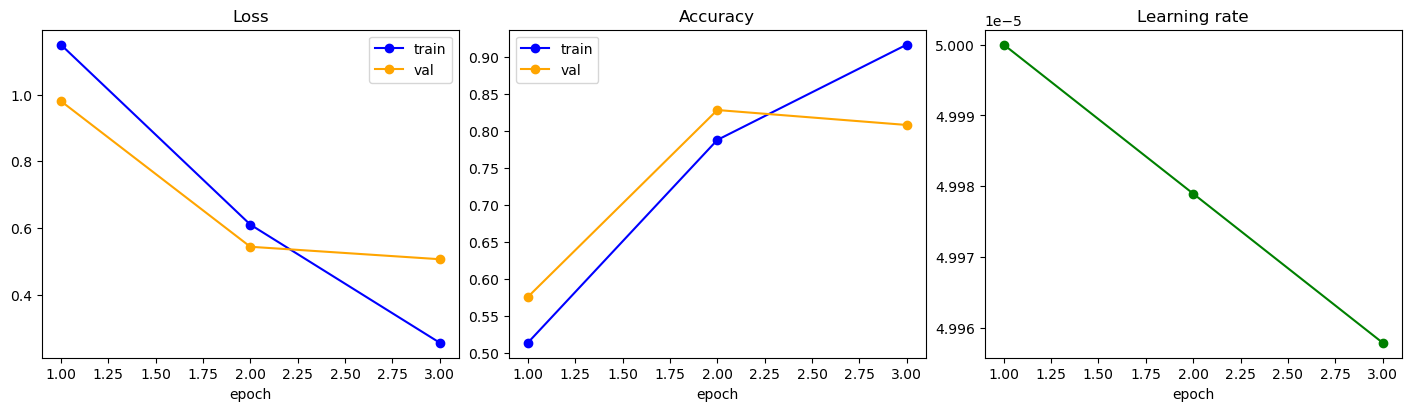

In [30]:
# mudeli treenimine ja progressi visualiseerimine
history = model.fit(train_dataset.batch(batch_size), epochs=num_epochs, validation_data=val_dataset.batch(batch_size))

epochs = np.arange(1, 4)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(14, 4))
ax1.set_title('Loss')
ax1.set_xlabel('epoch')
ax1.plot(epochs, history.history['loss'], c='blue', label='train', marker='o')
ax1.plot(epochs, history.history['val_loss'], c='orange', label='val', marker='o')
ax1.legend()
ax2.set_title('Accuracy')
ax2.set_xlabel('epoch')
ax2.plot(epochs, history.history['accuracy'], c='blue', label='train', marker='o')
ax2.plot(epochs, history.history['val_accuracy'], c='orange', label='val', marker='o')
ax2.legend()
ax3.set_title('Learning rate')
ax3.set_xlabel('epoch')
learning_rate = lr_scheduler(np.arange(num_epochs))
ax3.plot(epochs, learning_rate, c='green', marker='o')
plt.show()

Mudeli täpsuse (accuracy) hindamine testandmetel:

In [49]:
pred = model.predict(test_dataset.batch(batch_size))['logits'] # väljundväärtustele pole softmaxi rakendatud
y_pred = [np.argmax(vector) for vector in pred]

accuracy_score(test_labels, y_pred)

7/7 [==============================] - 15s 2s/step


0.8585858585858586

Mudel salvestatakse, sealjuures tekib automaatselt töökausta uus kaust.

In [32]:
model.save_pretrained('BERT_sentence_classification')

### V Hindamine

Mudeli headust saab hinnata rohkema, kui täpsuse (accuracy) kaudu testandmetel. Siin uuritakse mudeli sooritust mõnel uuel lausel. Samuti vaadatakse üle vale klassi saanud laused, sest võib juhtuda, et mudeli pakutav klass osutub sobilikumaks, kui varasemalt automaatselt märgendatud klass. Siiski tasub pidada silmas, et selline lähenemine sobib siinsel väikesel andmehulgal, kuid suurte andmehulkade korral ei pruugi olla võimalik kõiki vigu käsitsi üle vaadata. Viimaks tehakse precision-recall joonis.

Esmalt võetakse paar näitelauset ja vaadatakse, mis klasse mudel lausetele ennustab.

In [195]:
# salvestatud mudelit saab uuesti sisse lugeda
finetuned_model = TFAutoModelForSequenceClassification.from_pretrained('BERT_sentence_classification')
tokenizer = AutoTokenizer.from_pretrained("tartuNLP/EstBERT")

clf = pipeline("text-classification", model=finetuned_model, tokenizer=tokenizer)

Some layers from the model checkpoint at BERT_sentence_classification were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at BERT_sentence_classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Ennustatakse kahe uue lause klassid:

In [194]:
new_pred1 = clf.predict("Sel aastal valimistel ei osaleta.")
print(new_pred1)
new_pred2 = clf.predict("Erakond ei osale selle aasta valimistel.")
print(new_pred2)

[{'label': 'LABEL_4', 'score': 0.581658124923706}]
[{'label': 'LABEL_2', 'score': 0.8458204865455627}]


Nagu näha, on ennustatud klassid ('label') esitatud kodeeritud kujul. Et näha, mis klassinimed nende taga on, võib kasutada funktsioonide abi.

In [190]:
# funktsioon klassinime kättesaamiseks ja tagastamiseks sõnena
def get_classname(pred):
    # returns original classname
    classname = le.inverse_transform([int(pred[0]['label'][-1])])
    return str(classname[0])

# funktsioon, mis tagastab natuke muudetud kujul ennustuse
def get_sentence_prediction(sentence):
    # returns sentence with its' predicted class and score
    pred = clf.predict(sentence)
    classname = get_classname(pred)
    return [{'sentence': sentence, 'label': classname, 'score': pred[0]['score']}]

In [196]:
# lause, kus esineb küll siinse andmestiku klassiga 'valimised' otseselt seonduv verb, kuid puudub ilmutatud kujul tegija
get_sentence_prediction("Festivalil sel aastal ei osaleta.")

[{'sentence': 'Festivalil sel aastal ei osaleta.',
  'label': 'None',
  'score': 0.9677992463111877}]

In [197]:
# lause, kus esineb küll siinse andmestiku klassiga 'valimised' otseselt seonduv verb, kuid puudub ilmutatud kujul tegija
get_sentence_prediction("Valimistel sel aastal ei osaleta.")

[{'sentence': 'Valimistel sel aastal ei osaleta.',
  'label': 'None',
  'score': 0.717064380645752}]

In [199]:
# lause, kus tegijaks on 'kassid'
get_sentence_prediction("Kassid ei osale selle aasta valimistel.")

[{'sentence': 'Kassid ei osale selle aasta valimistel.',
  'label': 'valimised',
  'score': 0.838873565196991}]

In [192]:
# lause, kus tegijaks on 'erakond'
get_sentence_prediction("Erakond ei osale selle aasta valimistel.")

[{'sentence': 'Erakond ei osale selle aasta valimistel.',
  'label': 'valimised',
  'score': 0.8458204865455627}]

In [193]:
# lause, kus tegijaks on 'keskerakond', mis on tõenäoliselt treeningandmestikus esinenud; skoor eelnevast kõrgem
get_sentence_prediction("Keskerakond ei osale selle aasta valimistel.")

[{'sentence': 'Keskerakond ei osale selle aasta valimistel.',
  'label': 'valimised',
  'score': 0.9883395433425903}]

Näitelausete põhjal tundub, et mudel on õppinud, et klassi (mis pole None) võib suurema kindlustasemega määrata lausetele, kus on ilmutatud kujul tegevusega seotud tegija/agent. None-klassi võib jällegi määrata suurema kindlustasemega lausetele, kus ilmutatud kujul tegija/agent puudub. Ühtlasi ei paista suurt kaalu omavat see, kas tegija/agent on poliitikavaldkonna-spetsiifiline ('kassid' ja 'erakond' said peaaegu sama tulemuse) juhul, kui see entiteet on üldisem mõiste. Teiste entiteetidega võrreldes sai 'keskerakond' märgatavalt suurema kindlustaseme, mis tuleneb ilmselt sellest, et treeningandmetes olid tegija/agendi rollis spetsiifilisemad nimeüksused. Tuleb siiski märkida, et siin treenitud mudel on näitlik ning suuremal andmehulgal treenitud mudel annaks paremaid tulemusi, millest saaks kindlamaid järeldusi teha.

Järgnevalt leitakse testandmestikule tehtud ennustuste seast vigased ennustused, kus ennustatav klass ei ühti tegeliku klassiga ning väljastatakse vastavad laused ekraanile. Sellised laused saab vaadata käsitsi üle. Siin lauseid ümber märgendama ei hakata, kuid soovi korral võib seda teha lausetega, mis ilmselgelt muusse klassi kuuluda võiksid.

In [117]:
num_of_mistakes = 0

for i in range(len(y_pred)):
    if y_pred[i] != test_labels[i]:
        num_of_mistakes += 1
        tokens = [t for t in train_encodings[i].ids if  t > 3]
        print("TEKST:", tokenizer.decode(tokens))
        print("PRED_LABEL:", le.inverse_transform([y_pred[i]])[0], "TRUE_LABEL:", le.inverse_transform([test_labels[i]])[0])
        print()
print("Eksimusi kokku:", num_of_mistakes)
print("Eksimuste osakaal:", round((num_of_mistakes/len(y_pred))*100, 2), "%")

TEKST: et oli teada et esimene kaik koma kaks ja neli aga kuhu edasi minna mille koikuda.
PRED_LABEL: valitsemine TRUE_LABEL: vaidlused ja erimeelsused

TEKST: osakond tegeles ideoloogilise vastuluurega, oli puhendatud noorte mojutamisele ja muuhulgas on ta siis osalenud ka koos meelisega.
PRED_LABEL: None TRUE_LABEL: vaidlused ja erimeelsused

TEKST: aga nuud siis ongi asi selles, et tallinnas siis nagu me teame, luuakse siis valimisliit tegus tallinn, mille saravamad nimed paistavad siis hetkel olevat urmas soorumaa ja juri mois ja tuleb siis tunnistada ka seda, et kampaania meistriks on siis valitud sinna mart luik ja kui see ei ole mingi teine mart, luhike, mina lugesin sellest ka ajalehe.
PRED_LABEL: valitsemine TRUE_LABEL: valimised

TEKST: aga selle puhul selle puhul on ometigi naha, et meil on niivord tugev vastuseis, et see on tartu linn seal on seal on vaga palju inimesi seal on vaga head argumendid, kusjuures uks argumente on veel see, et, et see eriplaneerimine on moeldud e

Järgmiseks tehakse joonis täpsuse-saagise kõverast (precision-recall curve) kõigi klasside kohta, et hinnata klasside täpsuse ja saagise suhet. Selleks on vaja teisendada mudeli ennustused tõenäosusteks ja teisendada klassid binaarseteks.

Mudeli poolt antud ennustustele rakendatakse softmaxi funktsiooni, et saada kätte tõenäosused:

In [210]:
probabilities = tf.nn.softmax(pred)

In [212]:
print(probabilities[0])

tf.Tensor([0.9456334  0.0212262  0.0138625  0.01378725 0.00549071], shape=(5,), dtype=float32)


Klassid teisendatakse binaarseteks ja tehakse joonis:

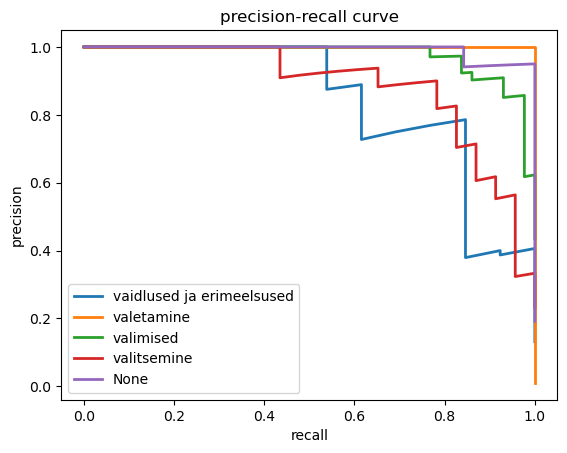

In [239]:
precision = dict()
recall = dict()

# vajalik samm, sest precision_recall_curve on mõeldud töötama binaarsete klassidega
Y = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])

for i in range(5): # 5 tähistab klasside arvu
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        probabilities[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=str(le.inverse_transform([i])[0]))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision-recall curve")
plt.show()

Jooniselt nähtuv klassi "valetamine" ideaalset tulemust (nii precision kui recall võrduvad ühega) ei peaks tõsiselt võtma, sest seda esines andmestikus väga vähe. Teiste klasside puhul on näha, et parim tulemus on saadud None-klassiga, millele järgneb klass "valimised", mis oli ühtlasi suurima esinemissagedusega klass.